In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import itertools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# import statsmodels.api as sm

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from bokeh.io import output_notebook, show
output_notebook()

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool

import ruptures as rpt

Loading BokehJS ...

In [ ]:
!pip install ruptures==1.0.1

In [2]:
prefix_path = 'interval_data/'
file_names = sorted(os.listdir(prefix_path))
file_names

['NMIA1.csv',
 'NMIA2.csv',
 'NMIA3.csv',
 'NMIG1.csv',
 'NMIG2.csv',
 'NMIM1.csv',
 'NMIM2.csv',
 'NMIR1.csv',
 'NMIR2.csv',
 'NMIS1.csv',
 'NMIS2.csv',
 'NMIS3.csv']

### Holiday Info

In [3]:
nmi = pd.read_csv('nmi_info.csv')
holidays = pd.read_csv('holidays.csv')

merged = nmi.merge(holidays, on='State')\
            .drop(['OutInterval', 'State'], axis=1)\
            .drop_duplicates()

nmi_with_holiday = merged.sort_values(['Nmi', 'LocalDate']).reset_index().drop('index',1)

# pick one to test
nmi_with_holiday[nmi_with_holiday['Nmi'] == 'NMIA1']

Nmi   LocalDate
0   NMIA1  2017-11-07
1   NMIA1  2017-12-25
2   NMIA1  2017-12-26
3   NMIA1  2018-01-01
4   NMIA1  2018-01-26
5   NMIA1  2018-03-12
6   NMIA1  2018-03-30
7   NMIA1  2018-04-02
8   NMIA1  2018-04-25
9   NMIA1  2018-06-11
10  NMIA1  2018-09-28

### Load one sample

In [4]:
df = pd.read_csv(prefix_path + file_names[3])
energy_df = df

### Check column E

In [5]:
for name in file_names:
    df = pd.read_csv(prefix_path + name)
    e_null = df['E'].isnull().sum()
    time_null = df['AESTTime'].isnull().sum()

    print(f"\n{name}:")
    print(f"{time_null} missing TimeStamp")
    print(f"{e_null} missing E")


NMIA1.csv:
0 missing TimeStamp
0 missing E

NMIA2.csv:
0 missing TimeStamp
0 missing E

NMIA3.csv:
0 missing TimeStamp
1416 missing E

NMIG1.csv:
0 missing TimeStamp
0 missing E

NMIG2.csv:
0 missing TimeStamp
0 missing E

NMIM1.csv:
0 missing TimeStamp
0 missing E

NMIM2.csv:
0 missing TimeStamp
0 missing E

NMIR1.csv:
0 missing TimeStamp
0 missing E

NMIR2.csv:
0 missing TimeStamp
0 missing E

NMIS1.csv:
0 missing TimeStamp
0 missing E

NMIS2.csv:
0 missing TimeStamp
0 missing E

NMIS3.csv:
0 missing TimeStamp
1416 missing E


1416 nulls in NMIA3.csv
1416 nulls in NMIS3.csv

### Check Time Range

In [6]:
for name in file_names:
    df = pd.read_csv(prefix_path + name)
    print(f"{name}  size: {df.shape}  from: {df.AESTTime.min()}  to: {df.AESTTime.max()}")

NMIA1.csv  size: (35040, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:45:00
NMIA2.csv  size: (35040, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:45:00
NMIA3.csv  size: (17520, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:30:00
NMIG1.csv  size: (17520, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:30:00
NMIG2.csv  size: (17520, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:30:00
NMIM1.csv  size: (17520, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:30:00
NMIM2.csv  size: (17520, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:30:00
NMIR1.csv  size: (17520, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:30:00
NMIR2.csv  size: (17520, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:30:00
NMIS1.csv  size: (17520, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:30:00
NMIS2.csv  size: (17520, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:30:00
NMIS3.csv  size: (17520, 2)  from: 2017-10-01 00:00:00  to: 2018-09-30 23:30:00


### A1, A2 use different sample rate: 15 mins , not 30 mins

In [7]:
NMIA2 = pd.read_csv(prefix_path + 'NMIA2.csv')

print(pd.DatetimeIndex(NMIA2['AESTTime']).shape)

NMIA2 = NMIA2.set_index(pd.DatetimeIndex(NMIA2['AESTTime']))\
             .drop(['AESTTime'], axis=1)

NMIA2.head()

(35040,)


E
AESTTime                 
2017-10-01 00:00:00  4.52
2017-10-01 00:15:00  4.28
2017-10-01 00:30:00  4.37
2017-10-01 00:45:00  4.65
2017-10-01 01:00:00  5.10

### NaN in: A3  and S3, Calcualte Percentage of Missing Value

In [8]:
df = pd.read_csv(prefix_path + 'NMIA3.csv')
a3_nans = df.loc[df['E'].isnull()]
null_percentage = df['E'].isnull().sum() / df.shape[0]
print(f"null_percentage: {null_percentage * 100}%")

df = pd.read_csv(prefix_path + 'NMIS3.csv')
s3_nans = df.loc[df['E'].isnull()]
null_percentage = df['E'].isnull().sum() / df.shape[0]
print(f"null_percentage: {null_percentage * 100}%")

null_percentage: 8.082191780821917%
null_percentage: 8.082191780821917%


In [9]:
a3_nans[['AESTTime']]

AESTTime
5904   2018-02-01 00:00:00
5905   2018-02-01 00:30:00
5906   2018-02-01 01:00:00
5907   2018-02-01 01:30:00
5908   2018-02-01 02:00:00
5909   2018-02-01 02:30:00
5910   2018-02-01 03:00:00
5911   2018-02-01 03:30:00
5912   2018-02-01 04:00:00
5913   2018-02-01 04:30:00
5914   2018-02-01 05:00:00
5915   2018-02-01 05:30:00
5916   2018-02-01 06:00:00
5917   2018-02-01 06:30:00
5918   2018-02-01 07:00:00
5919   2018-02-01 07:30:00
5920   2018-02-01 08:00:00
5921   2018-02-01 08:30:00
5922   2018-02-01 09:00:00
5923   2018-02-01 09:30:00
5924   2018-02-01 10:00:00
5925   2018-02-01 10:30:00
5926   2018-02-01 11:00:00
5927   2018-02-01 11:30:00
5952   2018-02-02 00:00:00
5953   2018-02-02 00:30:00
5954   2018-02-02 01:00:00
5955   2018-02-02 01:30:00
5956   2018-02-02 02:00:00
5957   2018-02-02 02:30:00
...                    ...
16002  2018-08-30 09:00:00
16003  2018-08-30 09:30:00
16004  2018-08-30 10:00:00
16005  2018-08-30 10:30:00
16006  2018-08-30 11:00:00
16007  2018-08-30 11:30:00
16032  2018-08-31 00:00:00
16033  2018-08-31 00:30:00
16034  2018-08-31 01:00:00
16035  2018-08-31 01:30:00
16036  2018-08-31 02:00:00
16037  2018-08-31 02:30:00
16038  2018-08-31 03:00:00
16039  2018-08-31 03:30:00
16040  2018-08-31 04:00:00
16041  2018-08-31 04:30:00
16042  2018-08-31 05:00:00
16043  2018-08-31 05:30:00
16044  2018-08-31 06:00:00
16045  2018-08-31 06:30:00
16046  2018-08-31 07:00:00
16047  2018-08-31 07:30:00
16048  2018-08-31 08:00:00
16049  2018-08-31 08:30:00
16050  2018-08-31 09:00:00
16051  2018-08-31 09:30:00
16052  2018-08-31 10:00:00
16053  2018-08-31 10:30:00
16054  2018-08-31 11:00:00
16055  2018-08-31 11:30:00

[1416 rows x 1 columns]

### EDA: visualize E value distribution

In [10]:
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import row
from numpy import histogram

it = iter(sorted(file_names))

for l, r in list(zip(it, it)):
    
    ldf = pd.read_csv(prefix_path + l)
    ldf = ldf.fillna(0)
    
    rdf = pd.read_csv(prefix_path + r)
    rdf = rdf.fillna(0)
    
    lp = figure(title=l[3:5], plot_height=300, plot_width=480)
    rp = figure(title=r[3:5], plot_height=300, plot_width=480)
    
    hist, edges = histogram(ldf.E, density=True, bins=50)
    hist2, edges2 = histogram(rdf.E, density=True, bins=50)
    
    lp.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white")
    rp.quad(top=hist2, bottom=0, left=edges2[:-1], right=edges2[1:], line_color="white")

    show(row(lp, rp))

### Preprocess pipeline

In [11]:
file_map = {}

for name in file_names:
    df = pd.read_csv(prefix_path + name)

    # NaN
    df.E = df.E.interpolate('nearest')
#     df = df.fillna(0)
    
    # index
    df = df.set_index(pd.DatetimeIndex(df['AESTTime'])).drop(['AESTTime'], axis=1)

    # aggregate by 30 mins interval only
    df = df.resample('30T').mean()
    
    assert df.shape[0] == 17520
    
    print('\n' + name + ' ====>')
    print(df.shape)
    print(df.head())
    
    file_map[name] = df


NMIA1.csv ====>
(17520, 1)
                         E
AESTTime                  
2017-10-01 00:00:00  7.495
2017-10-01 00:30:00  8.105
2017-10-01 01:00:00  8.635
2017-10-01 01:30:00  8.190
2017-10-01 02:00:00  8.405

NMIA2.csv ====>
(17520, 1)
                         E
AESTTime                  
2017-10-01 00:00:00  4.400
2017-10-01 00:30:00  4.510
2017-10-01 01:00:00  4.875
2017-10-01 01:30:00  4.510
2017-10-01 02:00:00  4.735

NMIA3.csv ====>
(17520, 1)
                        E
AESTTime                 
2017-10-01 00:00:00  7.23
2017-10-01 00:30:00  7.15
2017-10-01 01:00:00  7.31
2017-10-01 01:30:00  6.94
2017-10-01 02:00:00  7.00

NMIG1.csv ====>
(17520, 1)
                        E
AESTTime                 
2017-10-01 00:00:00  80.6
2017-10-01 00:30:00  79.0
2017-10-01 01:00:00  85.6
2017-10-01 01:30:00  85.5
2017-10-01 02:00:00  76.6

NMIG2.csv ====>
(17520, 1)
                          E
AESTTime                   
2017-10-01 00:00:00  117.36
2017-10-01 00:30:00  114.88
2017-1

In [12]:
file_map.keys()

dict_keys(['NMIA1.csv', 'NMIA2.csv', 'NMIA3.csv', 'NMIG1.csv', 'NMIG2.csv', 'NMIM1.csv', 'NMIM2.csv', 'NMIR1.csv', 'NMIR2.csv', 'NMIS1.csv', 'NMIS2.csv', 'NMIS3.csv'])

In [13]:
for k, df in file_map.items():
    print(f'asserting unique index number (17520) + no null column: {k}')
    
    # no null
    assert df['E'].isnull().sum() == 0
    
    # unique index
    assert len(df.index.unique()) == 17520

asserting unique index number (17520) + no null column: NMIA1.csv
asserting unique index number (17520) + no null column: NMIA2.csv
asserting unique index number (17520) + no null column: NMIA3.csv
asserting unique index number (17520) + no null column: NMIG1.csv
asserting unique index number (17520) + no null column: NMIG2.csv
asserting unique index number (17520) + no null column: NMIM1.csv
asserting unique index number (17520) + no null column: NMIM2.csv
asserting unique index number (17520) + no null column: NMIR1.csv
asserting unique index number (17520) + no null column: NMIR2.csv
asserting unique index number (17520) + no null column: NMIS1.csv
asserting unique index number (17520) + no null column: NMIS2.csv
asserting unique index number (17520) + no null column: NMIS3.csv


In [14]:
df.loc[df['E'].isnull()]

Empty DataFrame
Columns: [E]
Index: []

In [15]:
# set index
# df = df.set_index(pd.DatetimeIndex(df['AESTTime']))

### Preview dataframe after running pipeline

In [16]:
testdf = file_map['NMIG1.csv']
testdf.head()

E
AESTTime                 
2017-10-01 00:00:00  80.6
2017-10-01 00:30:00  79.0
2017-10-01 01:00:00  85.6
2017-10-01 01:30:00  85.5
2017-10-01 02:00:00  76.6

In [17]:
# testdf = file_map['NMIG1.csv']
# testdf.loc['2018-08-30':'2018-08-31'].head()

### EDA: Plot a graph for 30 days

In [18]:
days = 30

y = testdf['E'][:48 * days]
y.head()

AESTTime
2017-10-01 00:00:00    80.6
2017-10-01 00:30:00    79.0
2017-10-01 01:00:00    85.6
2017-10-01 01:30:00    85.5
2017-10-01 02:00:00    76.6
Freq: 30T, Name: E, dtype: float64

In [19]:
# simple x axis labels
# xlabels = list(map(lambda x: x.split(' ')[1][:5], y.index))
# xlabels[:10]

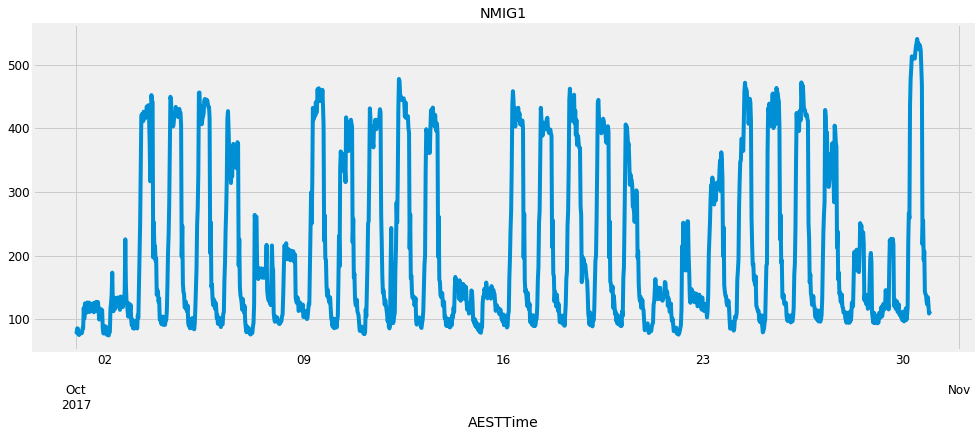

In [20]:
y.plot(
    figsize=(15, 6),
#     rot=90, 
    title='NMIG1'
)

# plt.xticks(np.arange(len(y.index)), xlabels)
# plt.show()

In [21]:
# series.groupby(series.index.hour).mean()
# series.groupby(pd.Grouper(freq='30min')).mean()

In [22]:
# from pandas import Series
# from pandas import DataFrame
# from pandas import Grouper
# from matplotlib import pyplot

# series = df['E']
# groups = series.groupby(pd.Grouper(freq='1h'))
# years = DataFrame()

# for k, v in groups:
# 	years[k] = 1 #v.values.mean()

# years

# years = years.T
# pyplot.matshow(years, interpolation=None, aspect='auto')
# pyplot.show()

### EDA: plot all time series to go through common patterns and locate anomaly

In [23]:
for file_name, df in file_map.items():
 
    # cast to date
#     df['AESTTime'] = pd.to_datetime(df['AESTTime'])

    TOOLS = "save,pan,box_zoom,reset,wheel_zoom"

    p = figure(title=file_name[3:5], 
               x_axis_type="datetime",
               y_axis_type="linear", 
               plot_height = 400,
               tools = TOOLS, 
               plot_width =980)

    p.xaxis.axis_label = 'Time'
    p.yaxis.axis_label = 'NMI reading'

    p.line(x=df.index, 
           y=df.E,
           line_color="purple")

    # format datetime
    p.add_tools(HoverTool(
        tooltips=[
            ( 'Time',  '@x{%F %T}'),
            ( 'Usage', '@y' ),
        ],
        formatters={
            'x': 'datetime',
        },
    ))

    show(p)

### Prediction: Case 1:    4 month ts data

(<Figure size 1296x432 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1c1e049b00>])

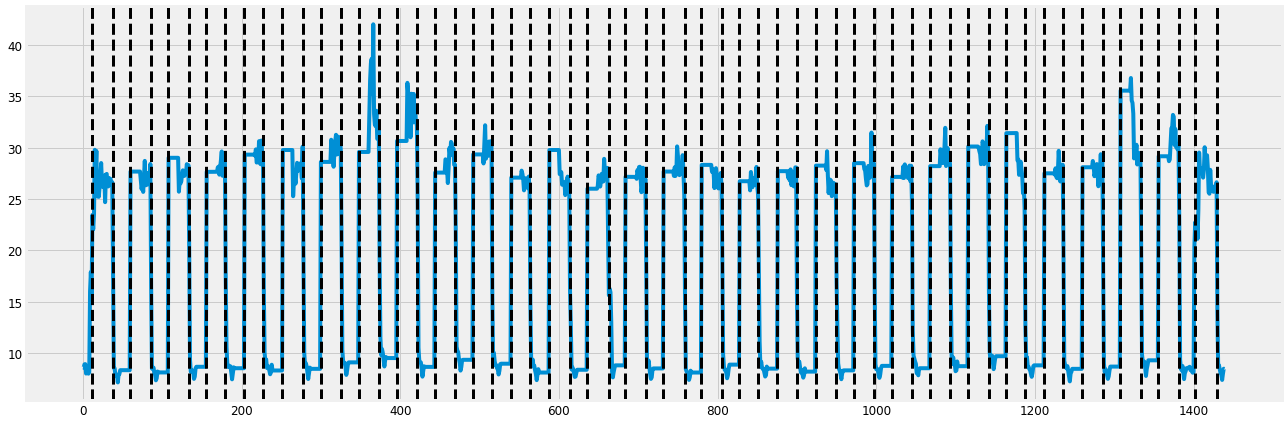

In [24]:
# testdf = file_map['NMIG1.csv']
# testdf = testdf.loc['2018-08-31':'2018-09-30']

testdf = file_map['NMIA3.csv']
testdf = testdf.loc['2018-01-31':'2018-05-31']

# pick data
days = 30
y = testdf['E'][:48 * days]

# series to df
signal = y.as_matrix(columns=None)

m = rpt.Pelt(model="rbf", jump=2, min_size=2).fit(signal) 

result = m.predict(pen=6)

rpt.display(signal, [], result, figsize=(18, 6))

### Case 2: order 3 lowpass butterworth filter + change point

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


(<Figure size 1296x432 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1c1e3158d0>])

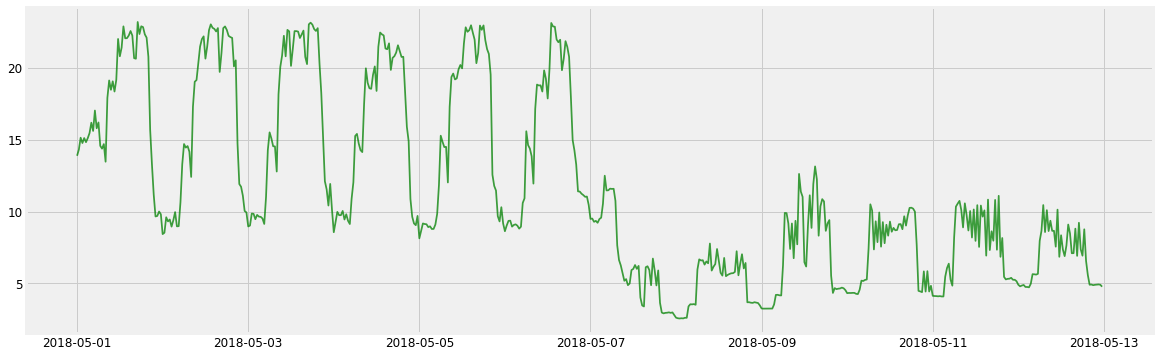

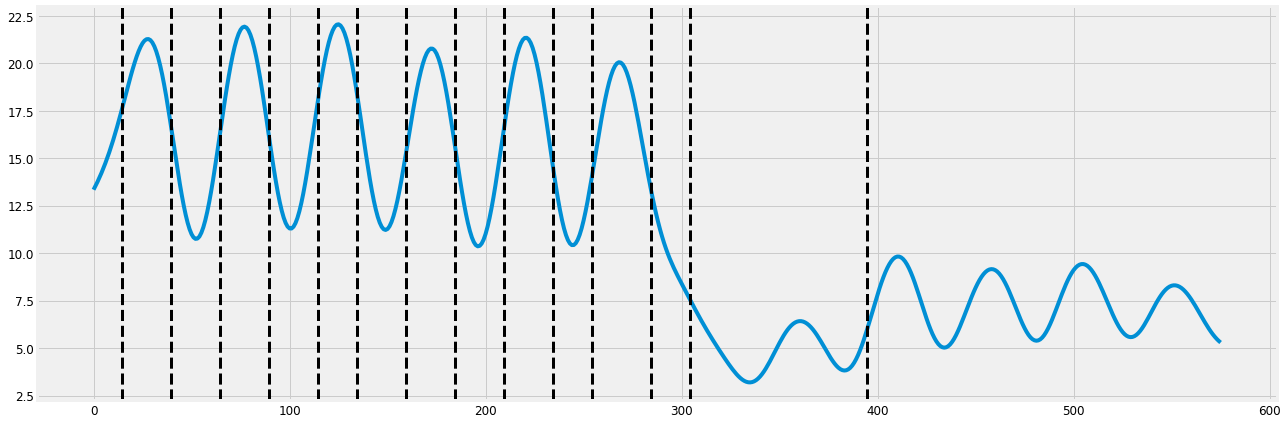

In [25]:
import ruptures as rpt

from numpy import sin, cos, pi, linspace
from numpy.random import randn
from scipy.signal import filtfilt, butter

from matplotlib.pyplot import plot, legend, show, grid, figure, savefig

testdf = file_map['NMIA1.csv']
# testdf = file_map['NMIA2.csv']
# testdf = file_map['NMIG1.csv']
# testdf = file_map['NMIS3.csv']

# testdf = testdf.loc['2018-05-01':'2018-06-01']
# testdf = testdf.loc['2018-03-31':'2018-04-30']
# testdf = testdf.loc['2018-01-01':'2018-02-17']

input_y = testdf.loc['2018-05-01':'2018-05-12']['E']
print(type(input_y)) # series

# Create an order 3 lowpass butterworth filter
b, a = butter(3, 0.05) 
y = filtfilt(b, a, input_y)

plt.figure(figsize=(18,6))
plot(input_y.index, input_y, 'g', linewidth=1.75, alpha=0.75)

signal = y
print(type(y))

# 4 hour as min seg distance
# Assume business hour > 6 hr
m = rpt.Pelt(model="rbf", min_size=6).fit(signal)

result = m.predict(pen=6)

rpt.display(signal, [], result, figsize=(18, 6))

###  Case: Moving average + change point

In [26]:
start_date = '2017-12-24'
end_date   = '2017-12-29'

In [27]:
day_mask = nmi_with_holiday.LocalDate.between(start_date, end_date, inclusive=True)

matched_holiday = nmi_with_holiday[day_mask][nmi_with_holiday.Nmi == 'NMIA1']

matched_holiday

/Users/mike/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Nmi   LocalDate
1  NMIA1  2017-12-25
2  NMIA1  2017-12-26

### Observe Holiday Curve and value, MA(10) + check point

[ 28  30  33  47  54  58  63  71  74  76  78  82  87  95 102 106 126 143
 151 174 199 206 223 247 271 275]


(<Figure size 1296x432 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1c1e30ca20>])

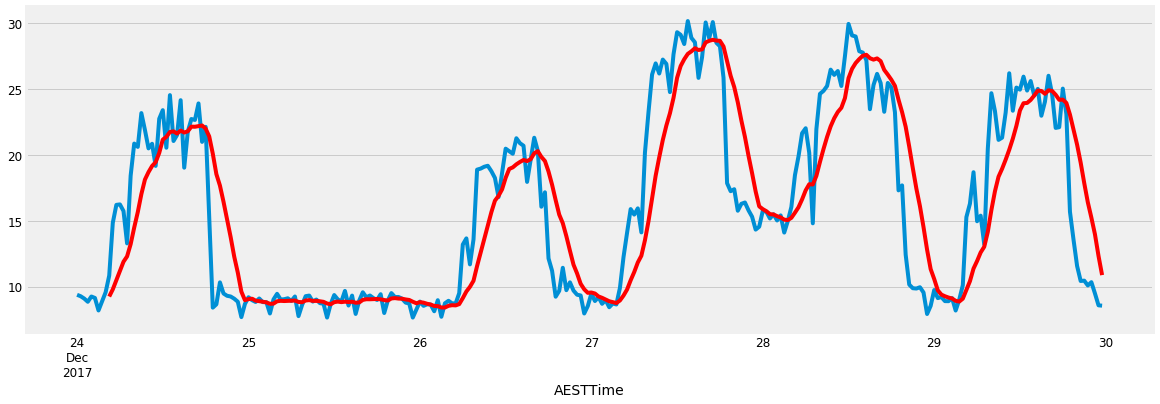

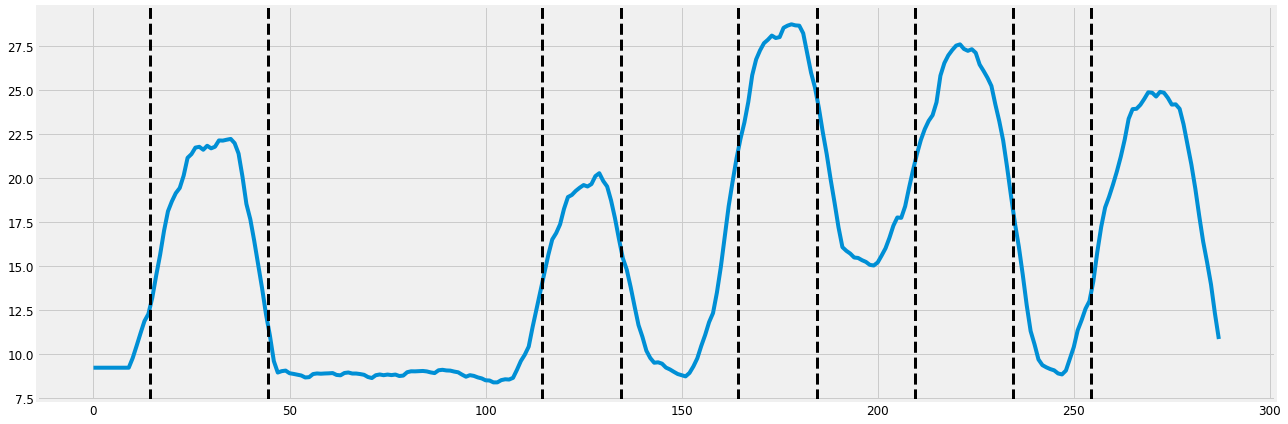

In [28]:
from scipy.signal import argrelmin

plt.figure(figsize=(18,6))

s = testdf.loc[start_date:end_date]['E']
s.plot()

# ma(10)
rolling = s.rolling(window=10)
ma10 = rolling.mean()

signal = ma10.interpolate('bfill')           # Series
ma10_signal = signal.as_matrix(columns=None) # Ndarray

lows = argrelmin(ma10_signal)[0]
print(lows)  # x

# plot
ma10.plot(color='red')

m = rpt.Pelt(model="rbf").fit(ma10_signal)
result = m.predict(pen=6)

# # Check point plot
rpt.display(signal, [], result, figsize=(18, 6))

#### Tried scipy.argrelmin, argrelextrema, scipy.misc.derivative, It require function to have exact form.

Ma(10) don't have exact form, so can't get stationary point or local mimima

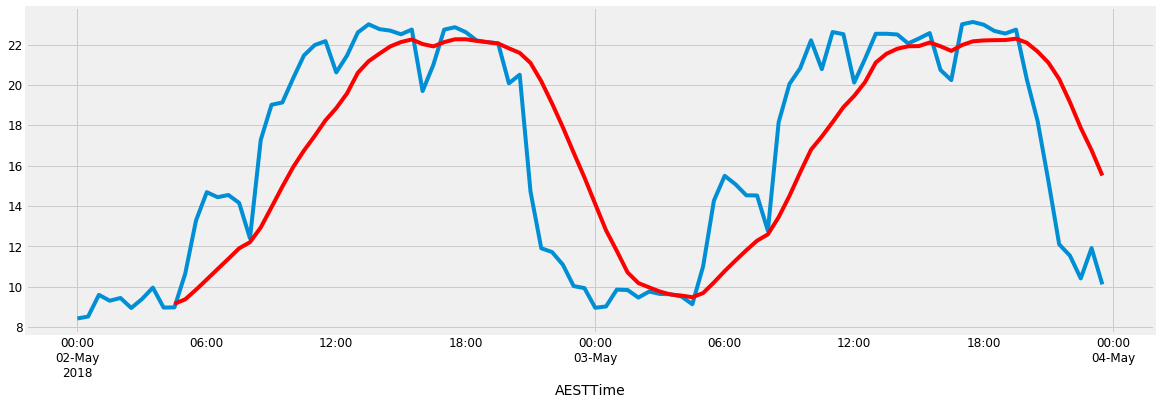

In [29]:
plt.figure(figsize=(18,6))

s = testdf.loc['2018-05-02':'2018-05-03']['E']
s.plot()

# ma
rolling = s.rolling(window=10)
ma10 = rolling.mean()
ma10.plot(color='red')

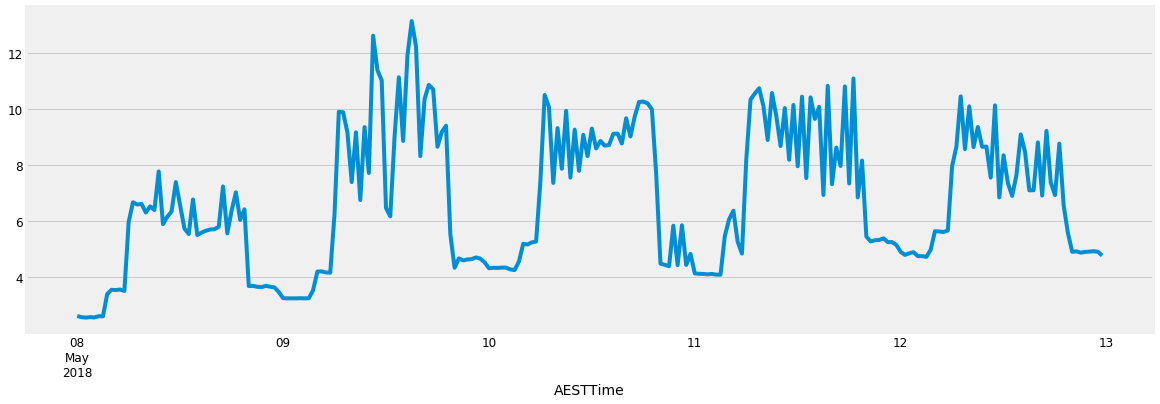

In [30]:
plt.figure(figsize=(18,6))
testdf.loc['2018-05-08':'2018-05-12']['E'].plot()

### Case: not smoothed change point detection

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


(<Figure size 1296x432 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1c1f5bc0b8>])

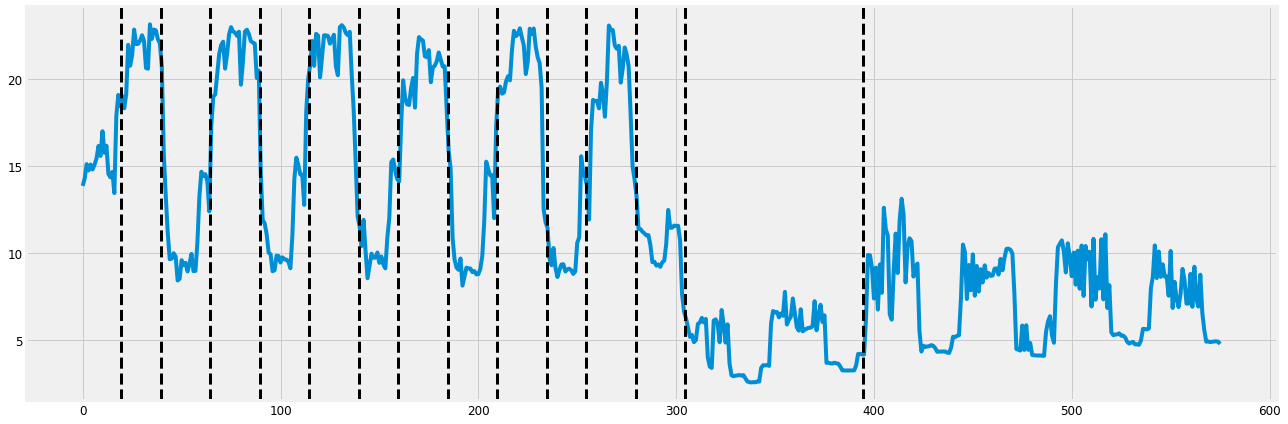

In [31]:
testdf = file_map['NMIA1.csv']

input_y = testdf.loc['2018-05-01':'2018-05-12']['E']
print(type(input_y)) # series

signal = input_y.as_matrix(columns=None) # series to df
print(type(signal))

# 4 hour as min seg distance. Assume business hour > 4hr
m = rpt.Pelt(model="rbf", min_size=8).fit(signal)

result = m.predict(pen=6)

rpt.display(signal, [], result, figsize=(18, 6))

### Discussion
change point algorithm pick middle point as `start of business`
since system has 30min lag, `true starting point` should be earlier than middle point

In [36]:
testdf.index.min(), testdf.index.max()

(Timestamp('2017-10-01 00:00:00', freq='30T'),
 Timestamp('2018-09-30 23:30:00', freq='30T'))

### Finished in < 40s on full date range, 7GB memory peak

In [269]:
test_file_name = 'NMIA1.csv'

In [149]:
testdf = file_map[test_file_name]

input_y = testdf.loc['2017-10-01':'2018-09-30']['E']

signal = input_y.as_matrix(columns=None) # series to df

# 4 hour as min seg distance. Assume business hour > 4hr
m = rpt.Pelt(model="rbf", min_size=10, jump=5).fit(signal)

result = m.predict(pen=6)

# Don't call display on large dataset
# rpt.display(signal, [], result, figsize=(18, 6))

In [150]:
# Trick: To skip exception
result.remove(17520)

# Check
result[-1]

In [267]:
# nth rows
rdf = testdf.iloc[result]

rdf.head(6)

E
AESTTime                   
2017-10-01 05:00:00  15.095
2017-10-01 20:00:00  14.230
2017-10-02 06:00:00  15.735
2017-10-02 21:00:00   8.875
2017-10-03 04:30:00  13.355
2017-10-03 19:30:00  20.650

In [268]:
rdf.shape

(689, 1)

### Excluding Holiday from business hours

In [342]:
# Check: datetime need to have both start and close
filted_biz_hr = rdf.groupby(rdf.index.date).filter(lambda x: x.count() == 2)

filted_biz_hr = filted_biz_hr.reset_index()

filted_biz_hr['T'] = filted_biz_hr.AESTTime.dt.date

filted_biz_hr.head(6)

AESTTime       E           T
0 2017-10-01 05:00:00  15.095  2017-10-01
1 2017-10-01 20:00:00  14.230  2017-10-01
2 2017-10-02 06:00:00  15.735  2017-10-02
3 2017-10-02 21:00:00   8.875  2017-10-02
4 2017-10-03 04:30:00  13.355  2017-10-03
5 2017-10-03 19:30:00  20.650  2017-10-03

In [343]:
# Current Meter's holiday
related_holiday = nmi_with_holiday[nmi_with_holiday['Nmi'] == test_file_name[:-4]] # NMIA1
related_holiday = related_holiday.reset_index()
related_holiday = related_holiday.rename(columns={'LocalDate':'T'})
related_holiday

T    Nmi
0   2017-11-07  NMIA1
1   2017-12-25  NMIA1
2   2017-12-26  NMIA1
3   2018-01-01  NMIA1
4   2018-01-26  NMIA1
5   2018-03-12  NMIA1
6   2018-03-30  NMIA1
7   2018-04-02  NMIA1
8   2018-04-25  NMIA1
9   2018-06-11  NMIA1
10  2018-09-28  NMIA1

In [344]:
# requirement for date field merge
filted_biz_hr['T'] = pd.to_datetime(filted_biz_hr['T'])
related_holiday['T'] = pd.to_datetime(related_holiday['T'])

In [345]:
# Test: left exclusing join, we exclude holiday dates from biz hour
# Jan 1st and 26th Dec are excluded
filted_biz_hr.iloc[156:].merge(related_holiday, on='T', how='left', indicator=True)\
                        .query('_merge == "left_only"')\
                        .drop(['_merge','T','Nmi'], 1).head(18)

AESTTime       E
0  2017-12-24 06:30:00  15.730
1  2017-12-24 19:00:00   8.395
4  2017-12-27 07:00:00  14.110
5  2017-12-27 19:30:00  17.240
6  2017-12-28 05:30:00  21.640
7  2017-12-28 20:30:00  10.145
8  2017-12-29 06:30:00  15.380
9  2017-12-29 19:00:00  15.685
10 2017-12-30 07:30:00  18.345
11 2017-12-30 20:00:00  10.780
12 2017-12-31 06:00:00  14.695
13 2017-12-31 18:30:00  19.645
16 2018-01-02 08:00:00  21.405
17 2018-01-02 20:30:00  17.310
18 2018-01-03 06:30:00  15.080
19 2018-01-03 19:00:00  19.035
20 2018-01-04 07:30:00  18.260
21 2018-01-04 20:00:00  17.050

In [346]:
# drop it
filted_biz_hr = filted_biz_hr.merge(related_holiday, on='T', how='left', indicator=True)\
    .query('_merge == "left_only"').drop(['_merge','T','Nmi'], 1)

In [347]:
filted_biz_hr.shape

(650, 2)

In [348]:
# data preparing
base_times = filted_biz_hr.AESTTime.dt.time

start_times = base_times[::2]
close_times = base_times[1::2]

print(start_times[0:3])
print(close_times[0:3])

0    05:00:00
2    06:00:00
4    04:30:00
Name: AESTTime, dtype: object
1    20:00:00
3    21:00:00
5    19:30:00
Name: AESTTime, dtype: object


In [349]:
# stringfy
start_times_in_str = list(map(lambda x: str(x), start_times.values))
close_times_in_str = list(map(lambda x: str(x), close_times.values))

start_times_in_str[:3], close_times_in_str[:3]

(['05:00:00', '06:00:00', '04:30:00'], ['20:00:00', '21:00:00', '19:30:00'])

In [350]:
from datetime import timedelta

def avg_time_in_str(start_times_in_str):
    return str(timedelta(seconds=sum(map(lambda f: int(f[0]) * 3600 + int(f[1]) * 60, 
                                        map(lambda f: f.split(':'), 
                                            start_times_in_str)
                                       )
                                   ) / len(start_times_in_str)))

In [351]:
avg_time_in_str(start_times_in_str)

'6:37:00.923077'

In [352]:
avg_time_in_str(close_times_in_str)

'20:12:33.230769'

### Demo: Interpolation of missing values

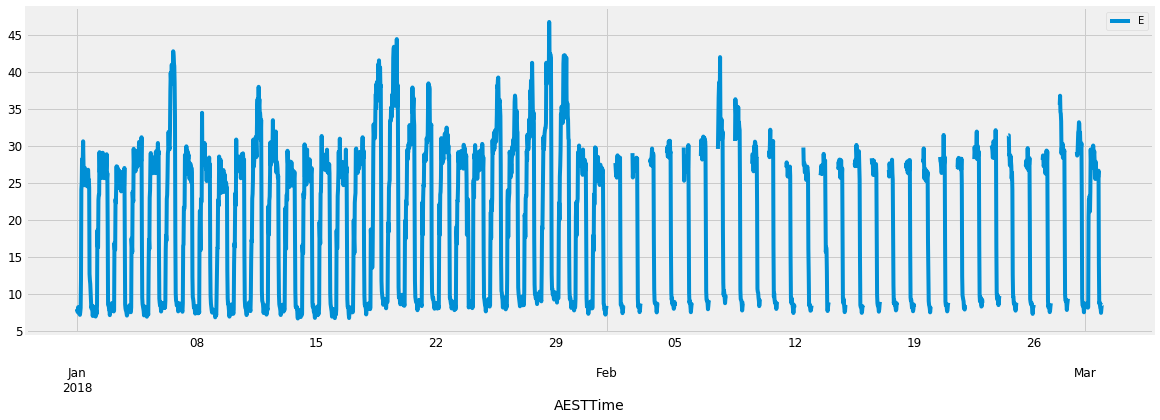

In [187]:
tdf = pd.read_csv(prefix_path + 'NMIA3.csv')

# handle missing value
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html
# nearest is better than linear and cubic, no abnormal value created

# tdf.E = tdf.E.interpolate('nearest')

tdf = tdf.set_index(pd.DatetimeIndex(tdf['AESTTime']))

tdf['2018-01-01':'2018-03-01'].plot(figsize=(18,6))

### After
we actually process the file early on

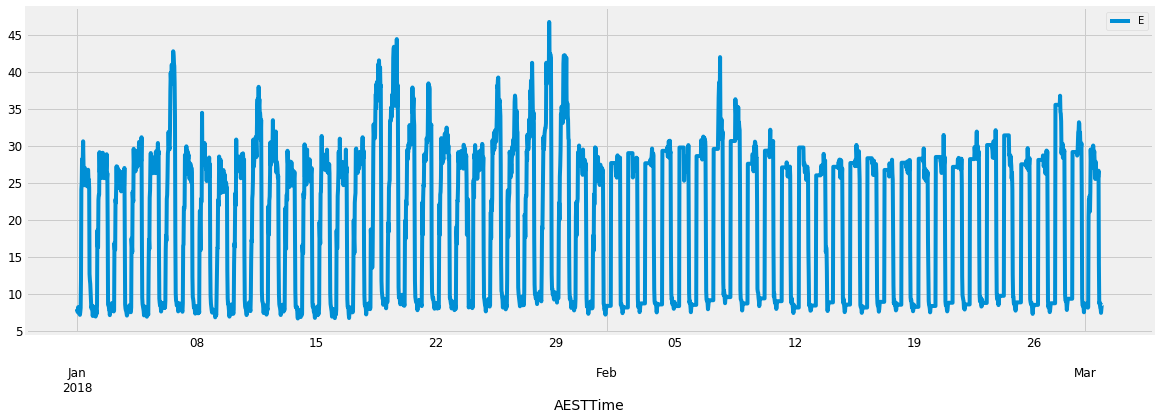

In [188]:
file_map['NMIA3.csv']['2018-01-01':'2018-03-01'].plot(figsize=(18,6))

### Future Extension

* Experiment 1: 
---------------
Peak detection includes local mimima. 

we need to run this on moving average of 10 to get the coordinates of local minima https://gist.github.com/gcalmettes/1784428

Possible result: 
http://billauer.co.il/peakdet.html


* Experiment 2: 
---------------
Run python script that use EM to improve checkpoint detection algorithm


* Experiment 3: 
---------------
Kmean (k=2) Clustering on low and high usage value. 

Classify into top and bottom group. (Ignoring middle point maybe)

Within a day, use last high's time to set business close time

use last low's time to set business start time


* Experiment 4:
---------------

switching autoregressive HMM

**notebook in: ECG_data/switching_autoregressive_HMM.ipynb**

idea:
https://stackoverflow.com/questions/11752727/pattern-recognition-in-time-series/11903770

work:
I've convert python 2 code to 3, you need to download ECG data.

Result is quite promissing, it might have performance issue and corner cases.

Code is very simple. Need to be code reviewed and publish to PyPI for further use.
<img src="files/auto_hmm.png">

* Experiment 5:

Modify moving z-socore algorithm for adaption

<img src="files/moving-zscore.png">

In [ ]:
# Experiment 1: Peak detection includes local mimima. 

# we need to run this on moving average of 10 to get the coordinates of local minima

# https://gist.github.com/gcalmettes/1784428

# Possible result: 
# http://billauer.co.il/peakdet.html

In [266]:
# Experiment 2: Run python script that use EM to improve checkpoint detection algorithm

In [ ]:
# Experiment 3: Clustering on low and high usage value. 
# Classify top and bottom. 
# Within a day, use last high's time to set business close time
# use last low's time to set business start time

### Deployment 

aws sagemaker for model inference

In [5]:
import os
from datetime import timedelta
import pandas as pd
import numpy as np

import ruptures as rpt

# csv
prefix_path = 'interval_data/'
file_names = sorted(os.listdir(prefix_path))

# holiday
nmi = pd.read_csv('nmi_info.csv')
holidays = pd.read_csv('holidays.csv')

merged = nmi.merge(holidays, on='State')\
            .drop(['OutInterval', 'State'], axis=1)\
            .drop_duplicates()

nmi_with_holiday = merged.sort_values(['Nmi', 'LocalDate']).reset_index().drop('index',1)

file_map = {}

# Preprocessing
for name in file_names:
    df = pd.read_csv(prefix_path + name)

    # NaN
    df.E = df.E.interpolate('nearest')
    
    # index
    df = df.set_index(pd.DatetimeIndex(df['AESTTime'])).drop(['AESTTime'], axis=1)

    # aggregate by 30 mins interval only
    df = df.resample('30T').mean()
    
    assert df.shape[0] == 17520
    
#     print('\n' + name + ' ====>')
#     print(df.shape)
#     print(df.head())
    
    file_map[name] = df
    
def avg_time_in_str(start_times_in_str):
    return str(timedelta(seconds=sum(map(lambda f: int(f[0]) * 3600 + int(f[1]) * 60, 
                                        map(lambda f: f.split(':'), 
                                            start_times_in_str)
                                       )
                                   ) / len(start_times_in_str)))

for test_file_name in file_names:

    testdf = file_map[test_file_name]

    input_y = testdf['E']

    signal = input_y.as_matrix(columns=None)

    m = rpt.Pelt(model="rbf", min_size=10, jump=5).fit(signal)

    result = m.predict(pen=6)

    result.remove(17520)
    
    # collect result: nth rows
    rdf = testdf.iloc[result]

    # date pair
    filted_biz_hr = rdf.groupby(rdf.index.date).filter(lambda x: x.count() == 2)

    filted_biz_hr = filted_biz_hr.reset_index()

    filted_biz_hr['T'] = filted_biz_hr.AESTTime.dt.date

    # related_holiday
    related_holiday = nmi_with_holiday[nmi_with_holiday['Nmi'] == test_file_name[:-4]] # NMIA1
    related_holiday = related_holiday.reset_index()
    related_holiday = related_holiday.rename(columns={'LocalDate':'T'})

    filted_biz_hr['T'] = pd.to_datetime(filted_biz_hr['T'])
    related_holiday['T'] = pd.to_datetime(related_holiday['T'])

    # drop it
    filted_biz_hr = filted_biz_hr.merge(related_holiday, on='T', how='left', indicator=True)\
        .query('_merge == "left_only"').drop(['_merge','T','Nmi'], 1)

    # data preparing
    base_times = filted_biz_hr.AESTTime.dt.time
    start_times = base_times[::2]
    close_times = base_times[1::2]
    
    # stringfy
    start_times_in_str = list(map(lambda x: str(x), start_times.values))
    close_times_in_str = list(map(lambda x: str(x), close_times.values))

    print('\n' + test_file_name)
    print(avg_time_in_str(start_times_in_str))
    print(avg_time_in_str(close_times_in_str))

/Users/mike/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.



NMIA1.csv
6:37:00.923077
20:12:33.230769

NMIA2.csv
6:16:36.610169
19:55:15.254237

NMIA3.csv
5:36:42.352941
19:25:40.588235

NMIG1.csv
6:38:36.279070
18:00:00

NMIG2.csv
7:36:41.694915
17:59:34.576271

NMIM1.csv
5:57:24.827586
16:10:20.689655

NMIM2.csv
4:30:00
15:20:00

NMIR1.csv
6:47:11.578947
19:22:01.052632

NMIR2.csv
7:34:40.924855
18:56:11.098266

NMIS1.csv
5:56:59.047619
16:52:32.380952

NMIS2.csv
5:44:17.142857
17:02:51.428571

NMIS3.csv
4:26:08.181818
16:05:00


### Architecture
https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/1P_kmeans_highlevel/kmeans_mnist.ipynb

https://docs.aws.amazon.com/sagemaker/latest/dg/getting-started-client-app.html
https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html
https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-main.html

For mobile device calling Lambda
https://docs.aws.amazon.com/lambda/latest/dg/with-android-example.html

Sample Notebook:

https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/1P_kmeans_highlevel/kmeans_mnist.ipynb

https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/1P_kmeans_lowlevel/kmeans_mnist_lowlevel.ipynb

* Training data store in s3

* SageMaker consume s3 to build model

* SageMaker deploy custom model as an end point

* InvokeEndpoint from AWS Lambda

Other services involved could be ECS docker, API gateway and load balancer for model endpoint a/b testing.
Sagemaker allows you to build and store model on s3, so rollback is quite easy.

### PoC Pseudo code for deployment and endpoint test
I've deploy DeepAR from github repo. With sageMaker role

In [ ]:
# create training job
create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": output_location
    },
    "ResourceConfig": {
        "InstanceCount": 2,
        "InstanceType": "ml.c4.8xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "k": "10",
        "feature_dim": "784",
        "mini_batch_size": "500",
        "force_dense": "True"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": data_location,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ]
}


sagemaker = boto3.client('sagemaker')

sagemaker.create_training_job(**create_training_params)

status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

# deploy
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

# create endpoint
create_endpoint_response = sagemaker.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)


# testing endpoint
import json

payload = np2csv(train_set[0][30:31])

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
print(result) # OK
